In [1]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [2]:
rows = pd.read_csv('content/outFrames/content.csv')
rows['class'] = rows['class'].fillna('None')

In [3]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
skip = 16
target_size = 16
for grp, values in grouped:
    if len(values) < target_size:
        continue

    # TODO: Can get more sample if values is larger than target_size frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)

    i = 0
    while i+target_size <= len(idxs):
        frame_ndarray = main_ndarray[idxs[i:i+target_size],]
        i+=skip
        frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))

In [4]:
rows.groupby(['class']).count()

,frame_name,video_name,interval,frame_number,type,path
class,,,,,,
None,1903,1903,1903,1903,1903,1903
UD,1700,1700,1700,1700,1700,1700
WF,2067,2067,2067,2067,2067,2067


In [5]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 234
Size of testing set 84


In [6]:
label_count = {}
for _, k in frames["Train"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 83, 'UD': 71, 'WF': 80}

In [7]:
label_count = {}
for _, k in frames["Test"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 22, 'WF': 38, 'UD': 24}

In [8]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


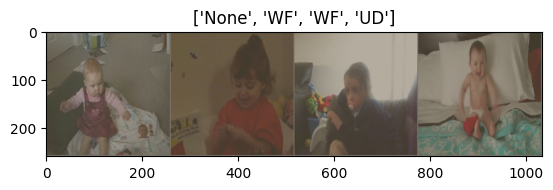

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

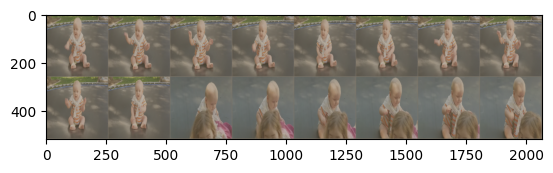

In [10]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [11]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            #if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
                #break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
    
    return model

In [12]:
model_ft = torchvision.models.video.mvit_v2_s(weights=torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1)
model_ft.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(768, len(class_names)),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/19
----------
Train Loss: 0.9360 Acc: 0.5897
Test Loss: 0.8419 Acc: 0.6667
Epoch 1/19
----------
Train Loss: 0.6901 Acc: 0.7350
Test Loss: 0.7461 Acc: 0.6905
Epoch 2/19
----------
Train Loss: 0.5356 Acc: 0.8077
Test Loss: 0.6606 Acc: 0.7381
Epoch 3/19
----------
Train Loss: 0.4457 Acc: 0.8291
Test Loss: 0.6684 Acc: 0.7381
Epoch 4/19
----------
Train Loss: 0.3947 Acc: 0.8718
Test Loss: 0.6735 Acc: 0.6905
Epoch 5/19
----------
Train Loss: 0.3002 Acc: 0.9103
Test Loss: 0.7158 Acc: 0.6905
Epoch 6/19
----------
Train Loss: 0.2673 Acc: 0.9188
Test Loss: 0.7124 Acc: 0.7024
Epoch 7/19
----------
Train Loss: 0.2335 Acc: 0.9402
Test Loss: 0.6896 Acc: 0.7024
Epoch 8/19
----------
Train Loss: 0.2147 Acc: 0.9444
Test Loss: 0.6769 Acc: 0.7143
Epoch 9/19
----------
Train Loss: 0.2166 Acc: 0.9444
Test Loss: 0.7066 Acc: 0.7262
Epoch 10/19
----------
Train Loss: 0.2017 Acc: 0.9530
Test Loss: 0.7193 Acc: 0.7143
Epoch 11/19
----------
Train Loss: 0.2019 Acc: 0.9487
Test Loss: 0.7088 Acc: 0.7262
Ep

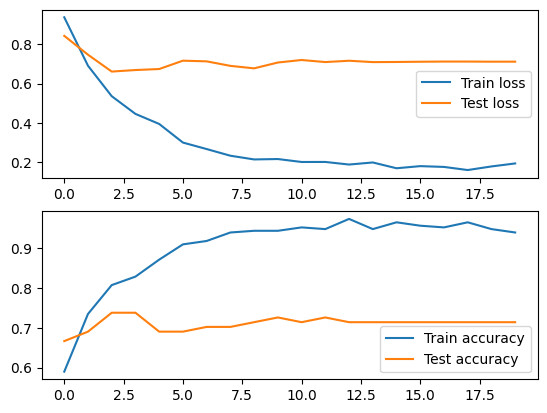

In [13]:
model_transform = torchvision.models.video.MViT_V2_S_Weights.KINETICS400_V1.transforms()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=20)

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(model_transform(inputs.to(device)))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])